In [1]:
import scipy

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
)
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
warnings.simplefilter("ignore")

In [3]:
format_plots()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 30
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

In [5]:
def fit_params(counts, n_splines, age):
    spline_class, splines = create_splines(age_samples, df=n_splines)
    scale = 0.2

    A = spline_class.transform(age_normalizer(age)).T

    theta_list = []
    for i in range(n_syllables):
        _theta, _ = scipy.optimize.nnls(A.T, (counts + 1)[:, i] * scale)
        theta_list.append(_theta)
    theta_list = np.array(theta_list).T
    theta_list = np.where(theta_list == 0, 1e-3, theta_list)
    params = {'basis_weights': jnp.log(jnp.array(theta_list.T))}
    return params

## Run held-out fitting to determine number of splines

In [6]:
# use_log_age = False
# age_normalizer, age_unnormalizer = age_normalizer_factory(
#     min_age=1, max_age=130, log_transform=use_log_age
# )
# age_samples = np.linspace(0, 1, 1000)
# age_sd = age_normalizer(10)

# hypparams = {
#     "age_sd": age_sd,
#     "params_sd": 1,
# }

# pbar = tqdm(range(4, 28, 3))

# out_ll = {}

# for n_splines in pbar:
#     fold = StratifiedShuffleSplit(n_splits=4, test_size=0.5, random_state=0)
#     spline_class, splines = create_splines(age_samples, df=n_splines)
    
#     params = fit_params(syllable_counts_jax, n_splines, age)

#     lls = []
#     for i, (train_index, test_index) in enumerate(fold.split(age, age)):
#         ll_fun = partial(
#             neg_log_likelihood,
#             bases=splines,
#             age_samples=age_samples,
#             true_age=age_normalizer(age[train_index]),
#             counts=syllable_counts_jax[train_index] + 1,
#             hypparams=hypparams,
#         )
#         optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

#         heldout_nll = neg_log_likelihood(
#             optimized_params,
#             splines,
#             age_samples,
#             age_normalizer(age[test_index]),
#             syllable_counts_jax[test_index] + 1,
#             hypparams=hypparams,
#             heldout=True,
#         )
#         out_ll[(n_splines, i)] = -heldout_nll
#         lls.append(-heldout_nll)
#         # print("n_splines", n_splines, "sd", hypparams["params_sd"], "ll", -heldout_nll)

In [7]:
# heldout_ll_df = (
#     pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
#     .rename_axis(["n_splines", "fold"], axis=1)
#     .melt(value_name="log_likelihood")
# )
# fig = figure(2, 1.5)
# ax = sns.lineplot(data=heldout_ll_df, x="n_splines", y="log_likelihood", err_kws=dict(lw=0))
# ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
# sns.despine()

In [8]:
# heldout_ll_df.groupby('n_splines')['log_likelihood'].mean().sort_values(ascending=False)

In [9]:
# bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
# distribution = tfp.distributions.DirichletMultinomial(
#     total_count=syllable_counts_jax.sum(axis=1)[:, None],
#     concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
# )
# syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

# bio_ages = get_biological_age(
#     optimized_params,
#     splines,
#     age_samples,
#     age_normalizer(age),
#     syllable_counts_jax + 1,
#     hypparams,
#     age_unnormalizer,
# )

In [10]:
# plot_syllables = 6
# x = age_unnormalizer(age_samples[::4])

# fig, ax = plt.subplots(
#     plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
# )
# for syllable in range(plot_syllables):
#     avg_sample = syllable_samples[..., syllable].mean(0)
#     a = ax[syllable, 0]
#     a.plot(x, avg_sample, label="Model fit")
#     a.plot(
#         age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
#     )
#     a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
#     l = a.legend(fancybox=False)
#     l.get_frame().set_linewidth(0)
#     a = ax[syllable, 1]
#     a.plot(x, avg_sample, label="Model fit")
#     a.plot(
#         bio_ages,
#         syllable_counts_jax[:, syllable],
#         "o",
#         label="Bio ages",
#         alpha=0.6,
#         mew=0,
#         ms=3,
#         c="C2",
#     )
#     a.set(xlabel="Biological age (weeks)")
#     l = a.legend(fancybox=False)
#     l.get_frame().set_linewidth(0)
# sns.despine()
# fig.tight_layout()

## Run a low spline-count model

In [11]:
n_splines = 9
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

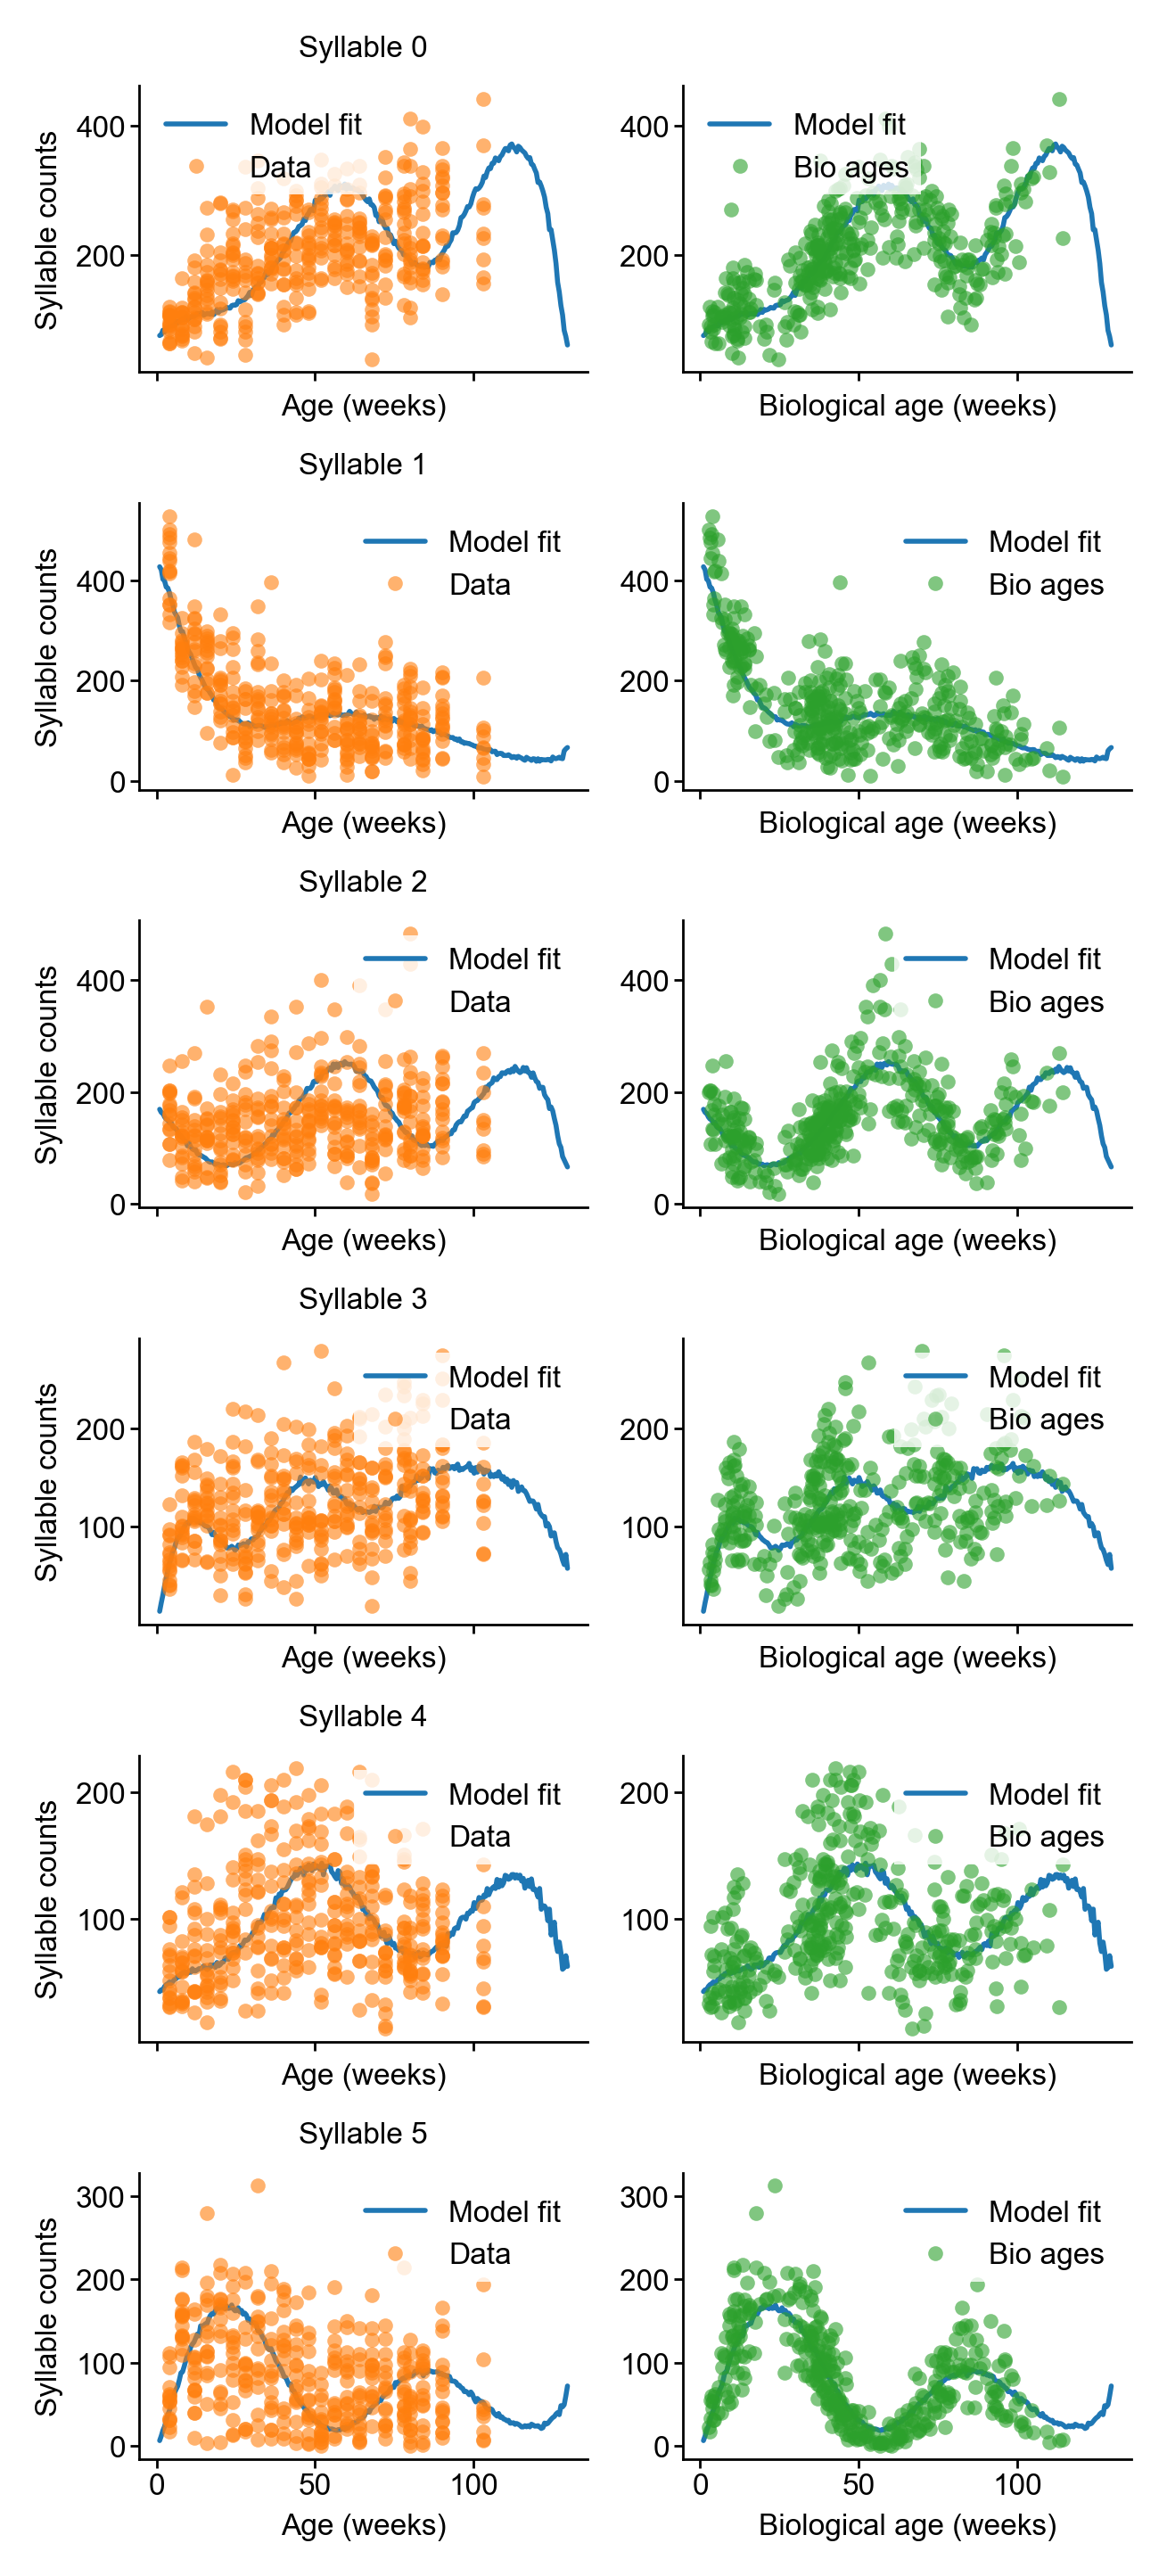

In [12]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Run a high spline-count model

In [14]:
n_splines = 20
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

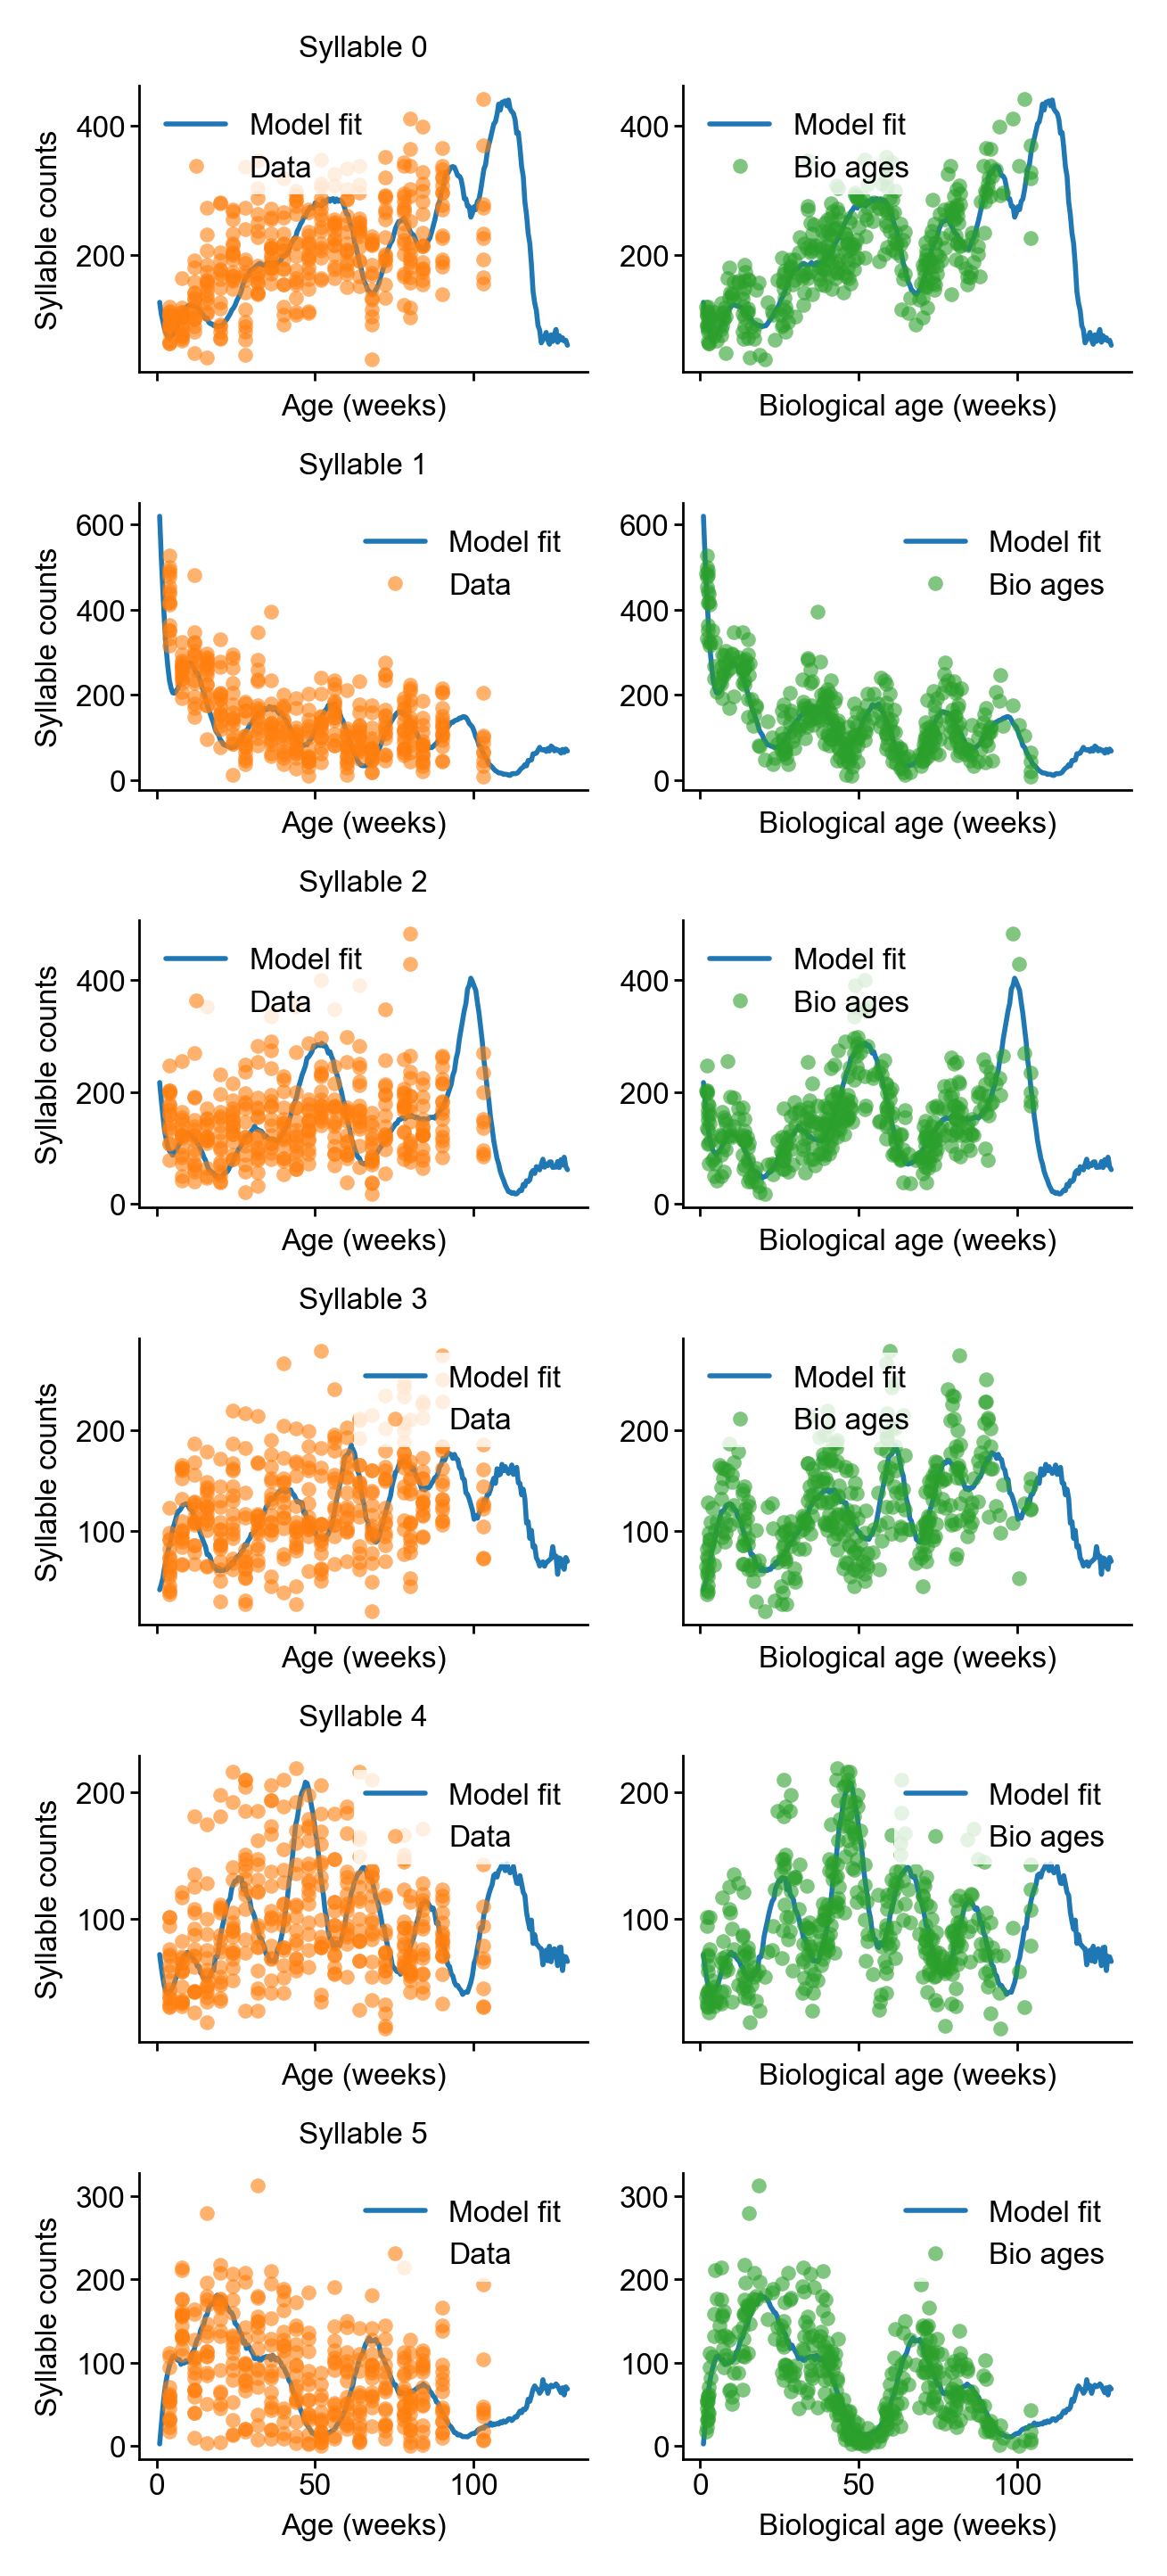

In [15]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Run a low spline-count model with high age SD

In [16]:
n_splines = 9
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(50)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

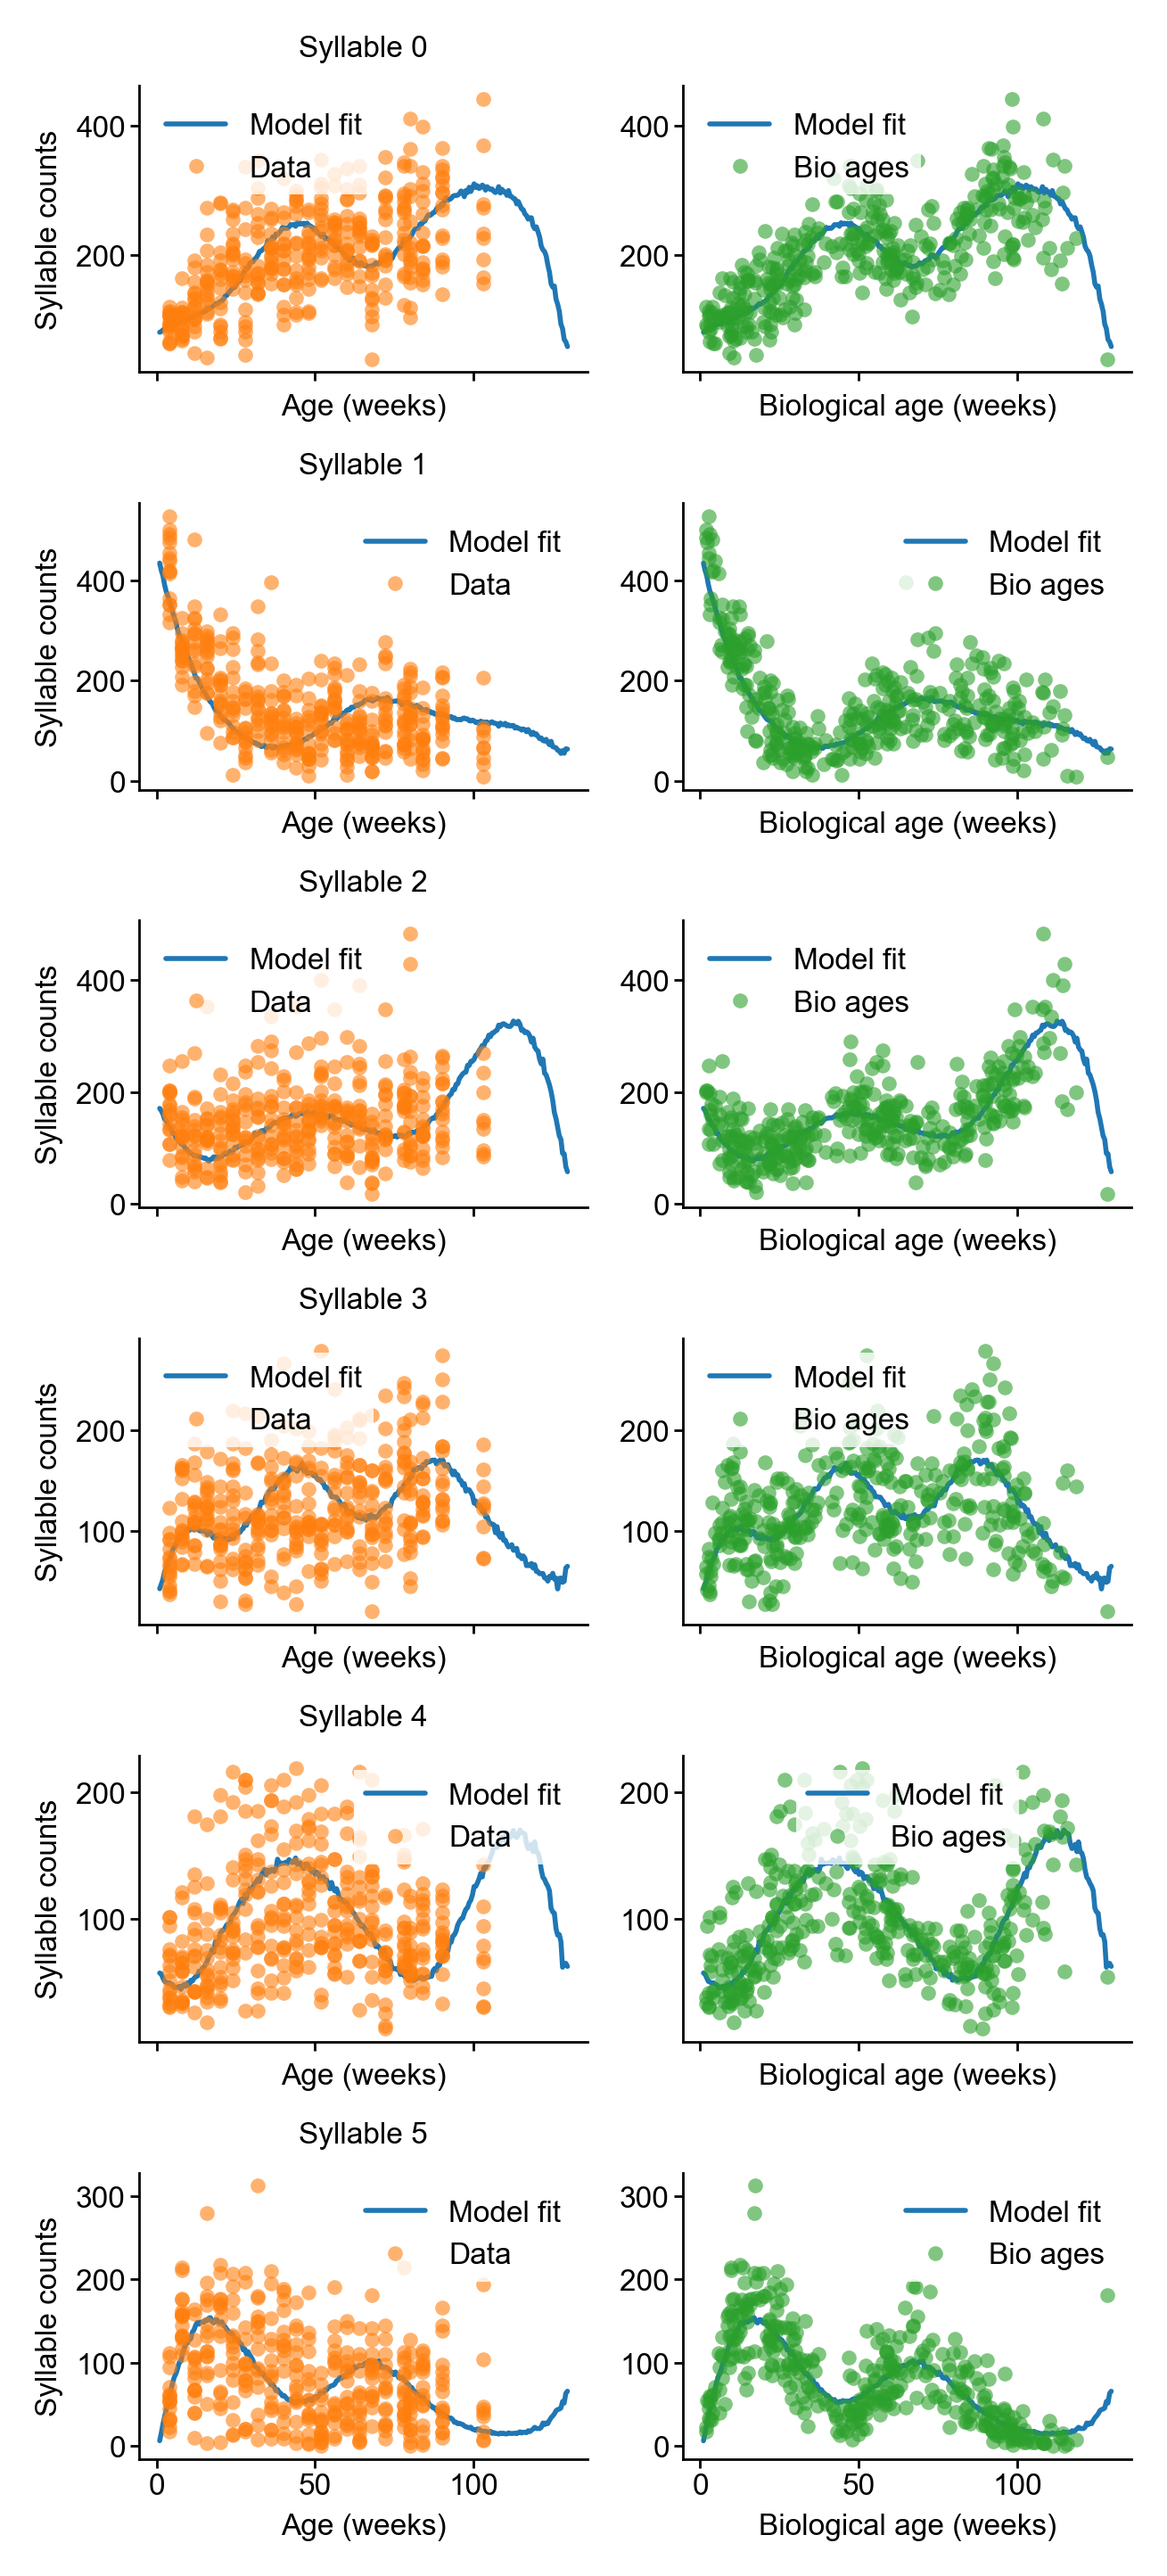

In [17]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Run a low spline-count model with low age SD

In [18]:
n_splines = 9
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(1.5)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

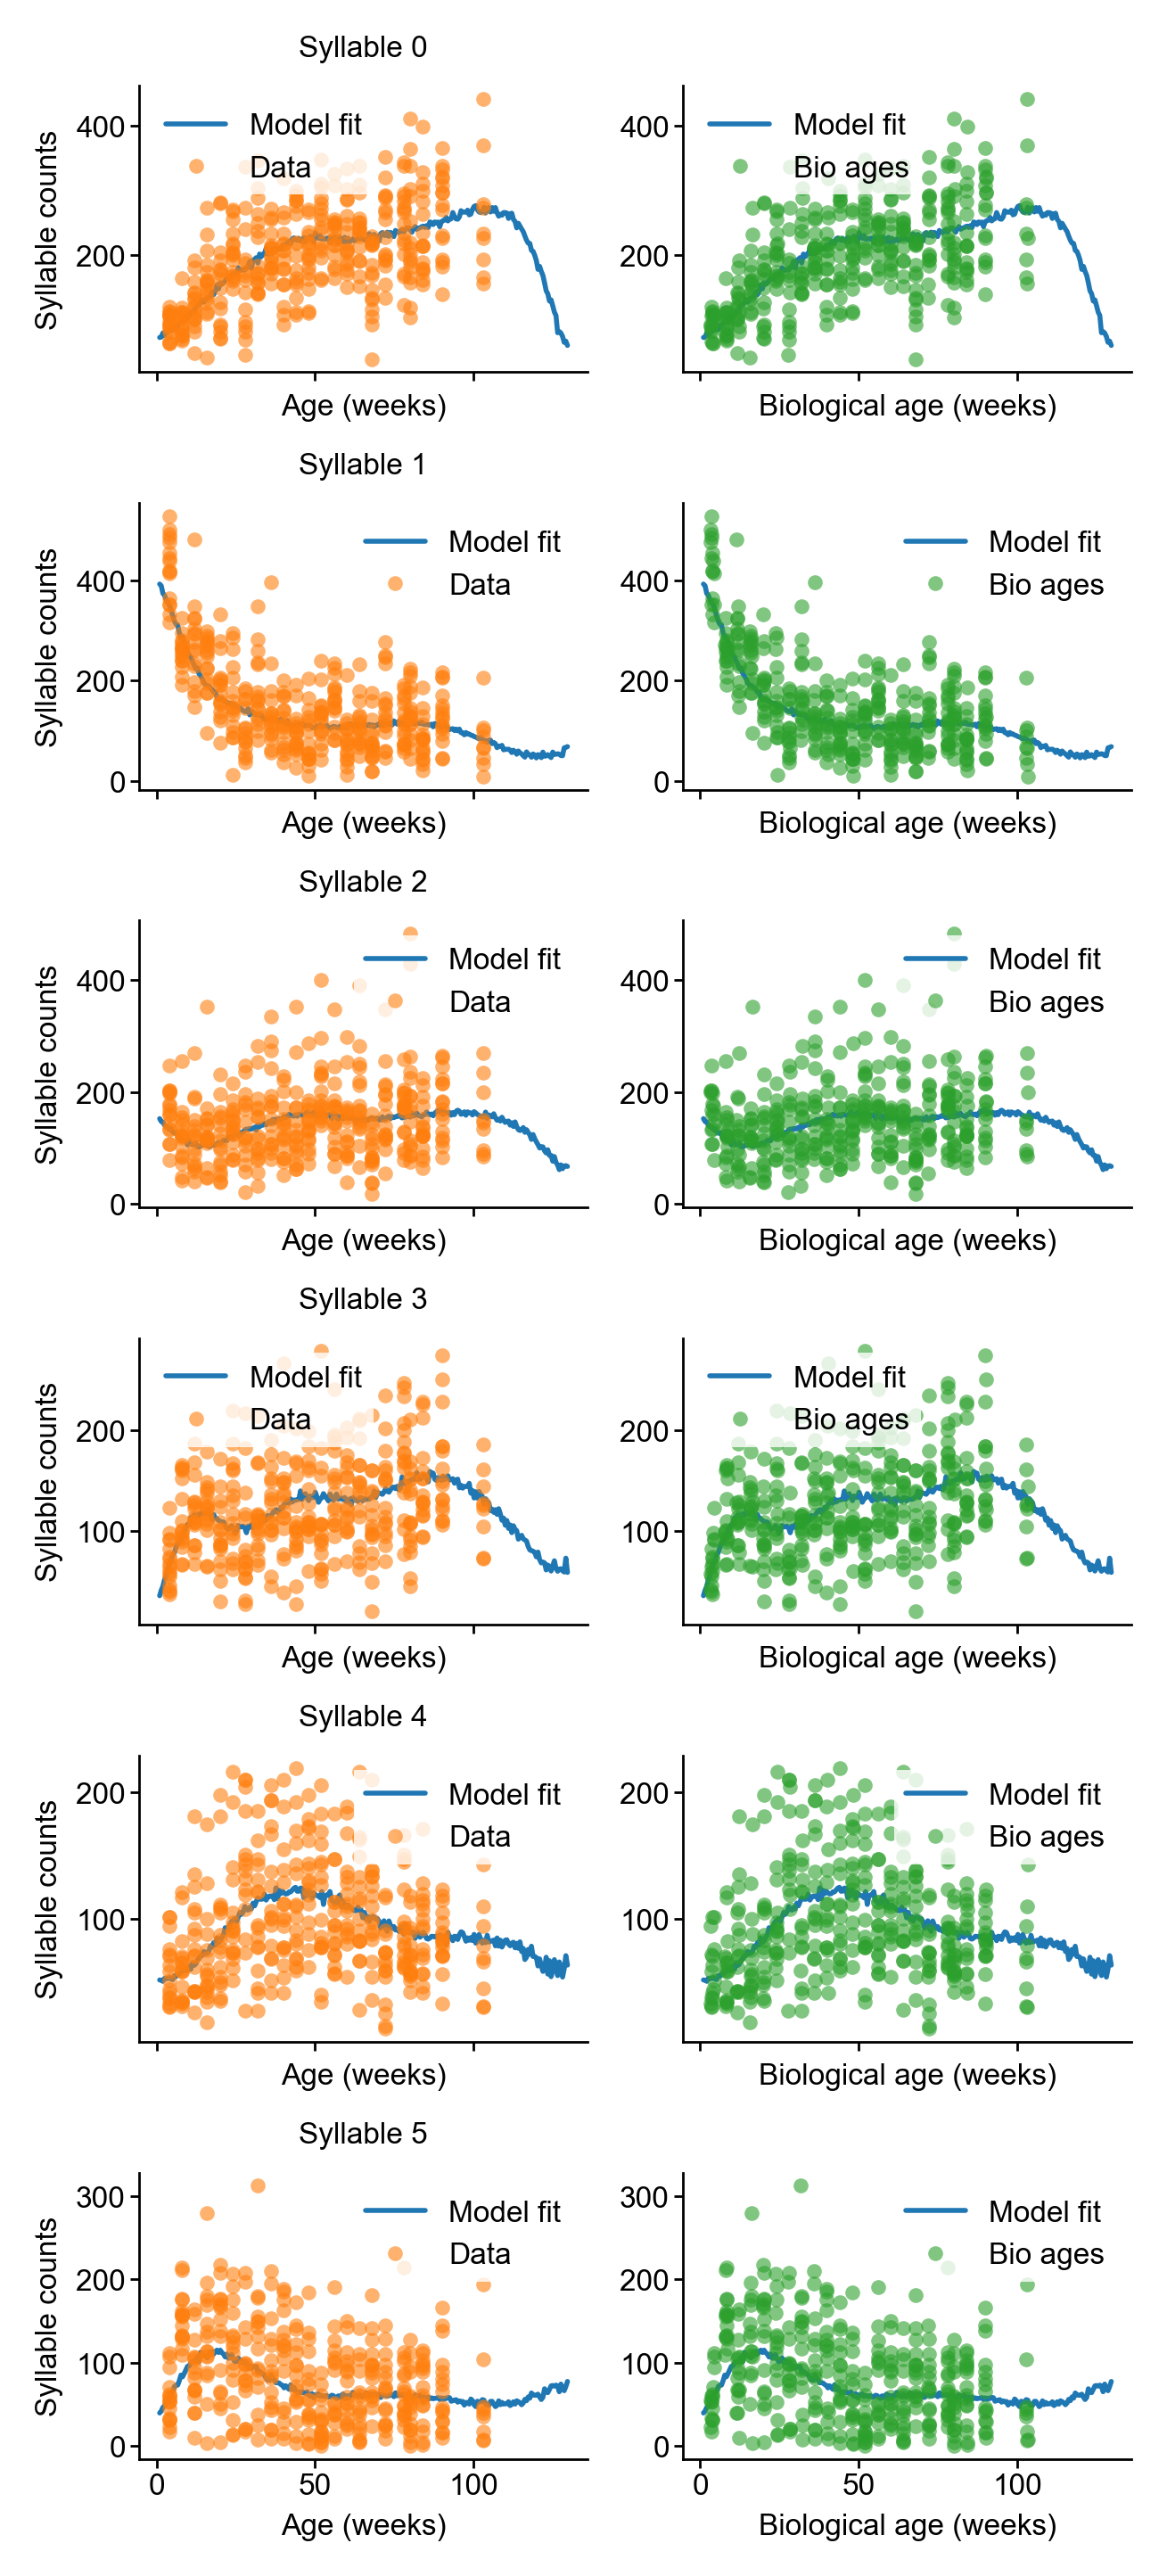

In [19]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Run a low spline-count model age log xform

In [20]:
n_splines = 9
use_log_age = True
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

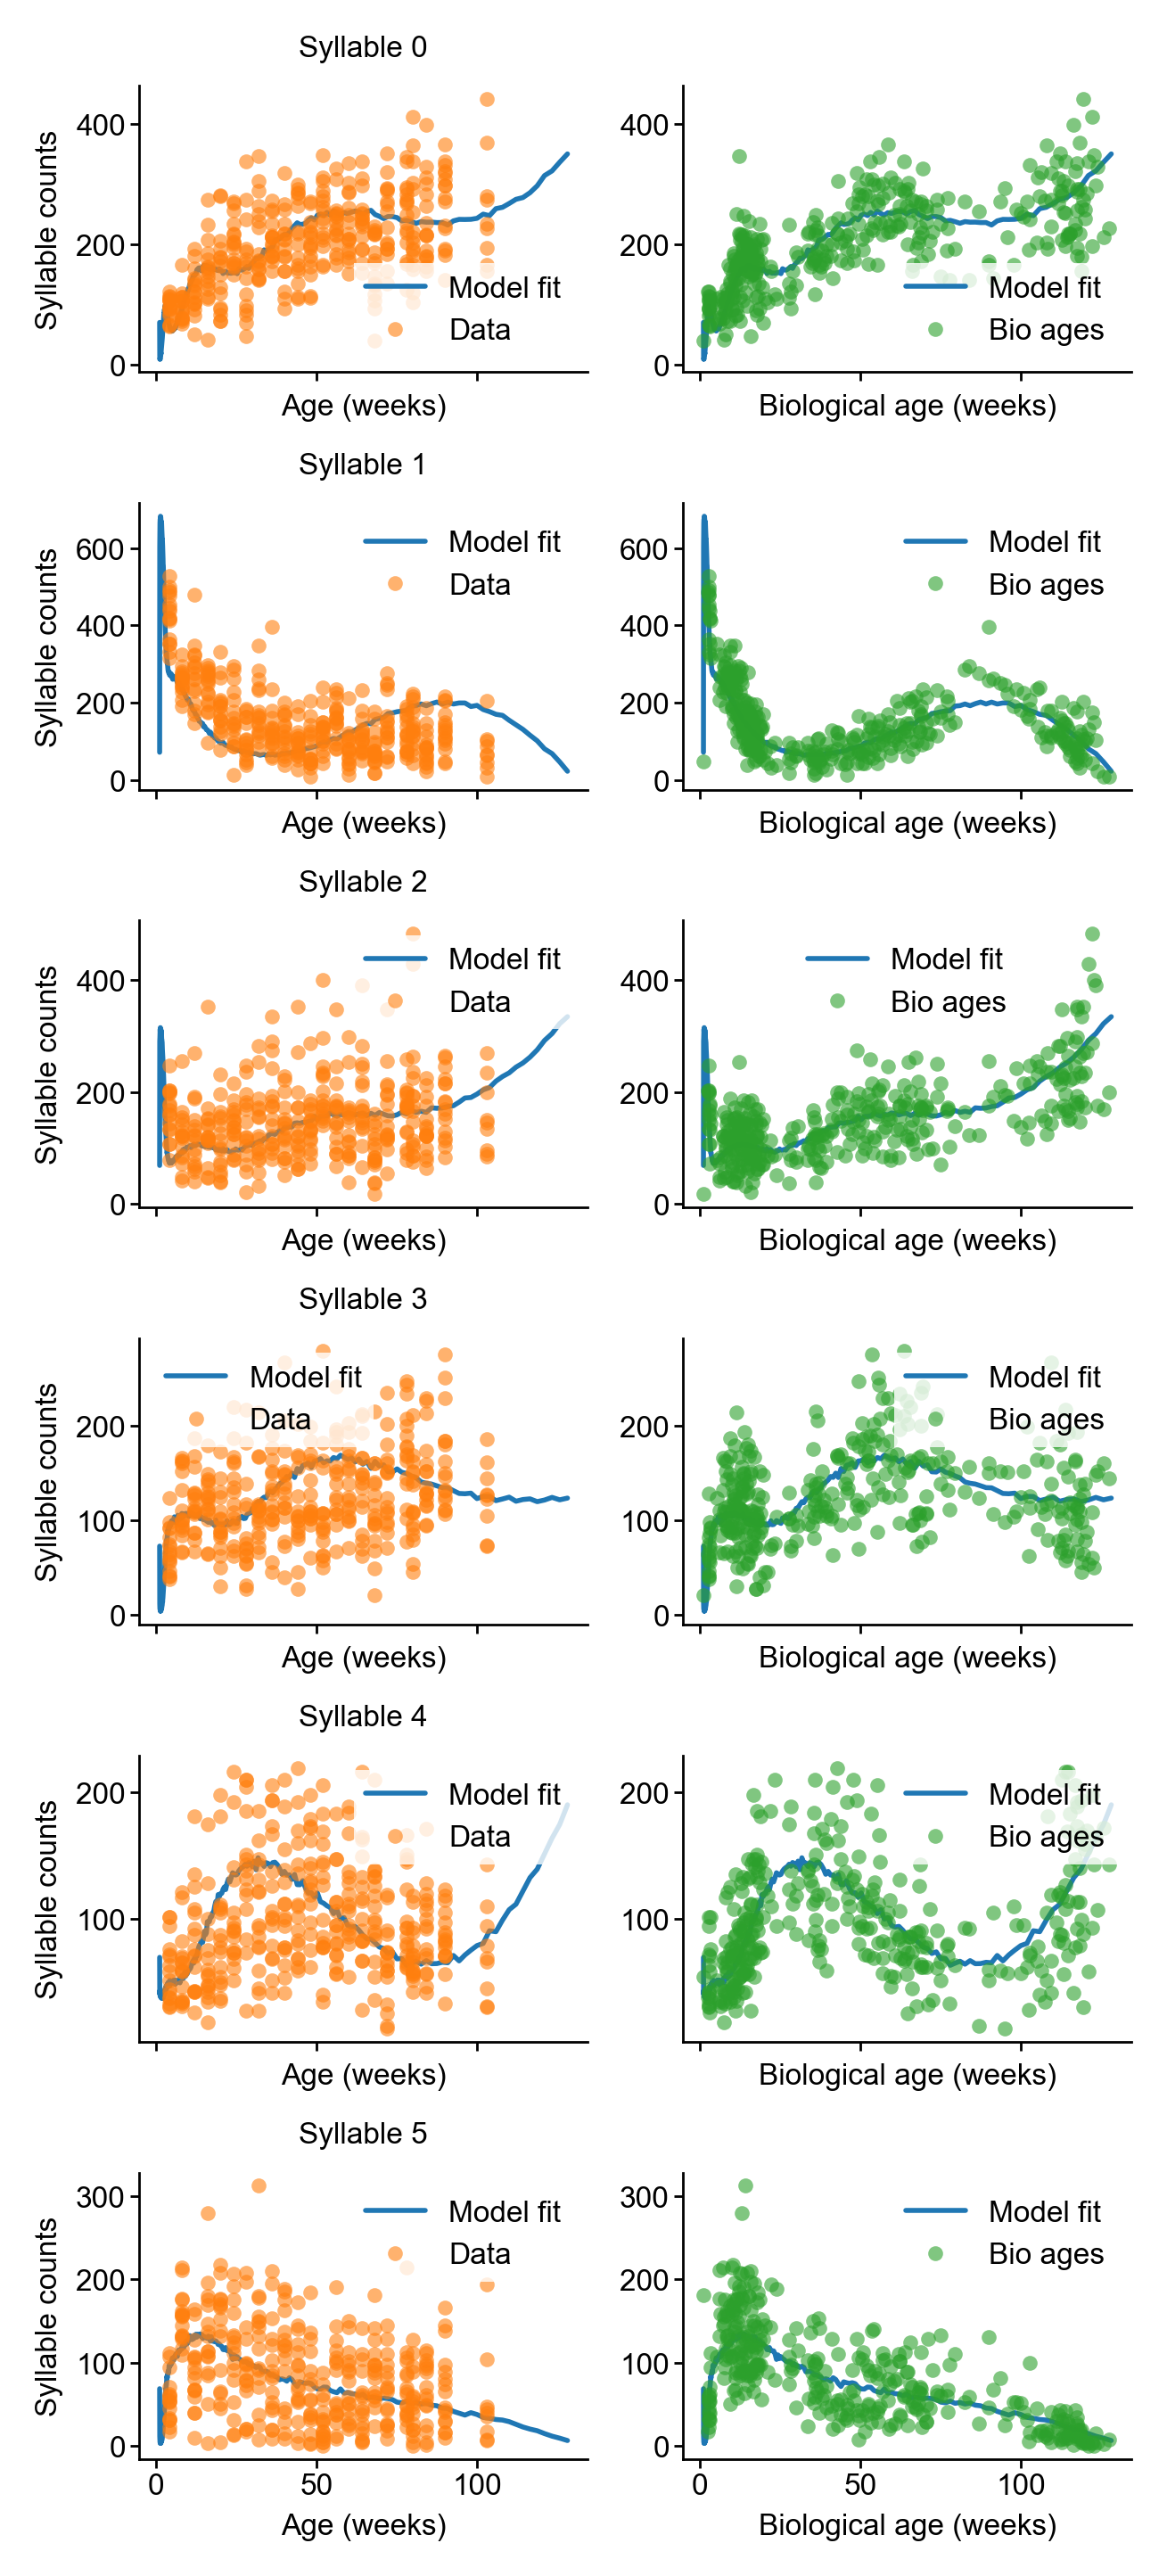

In [21]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Run a high spline-count model age log xform

In [22]:
n_splines = 20
use_log_age = True
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 1,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=50)

bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

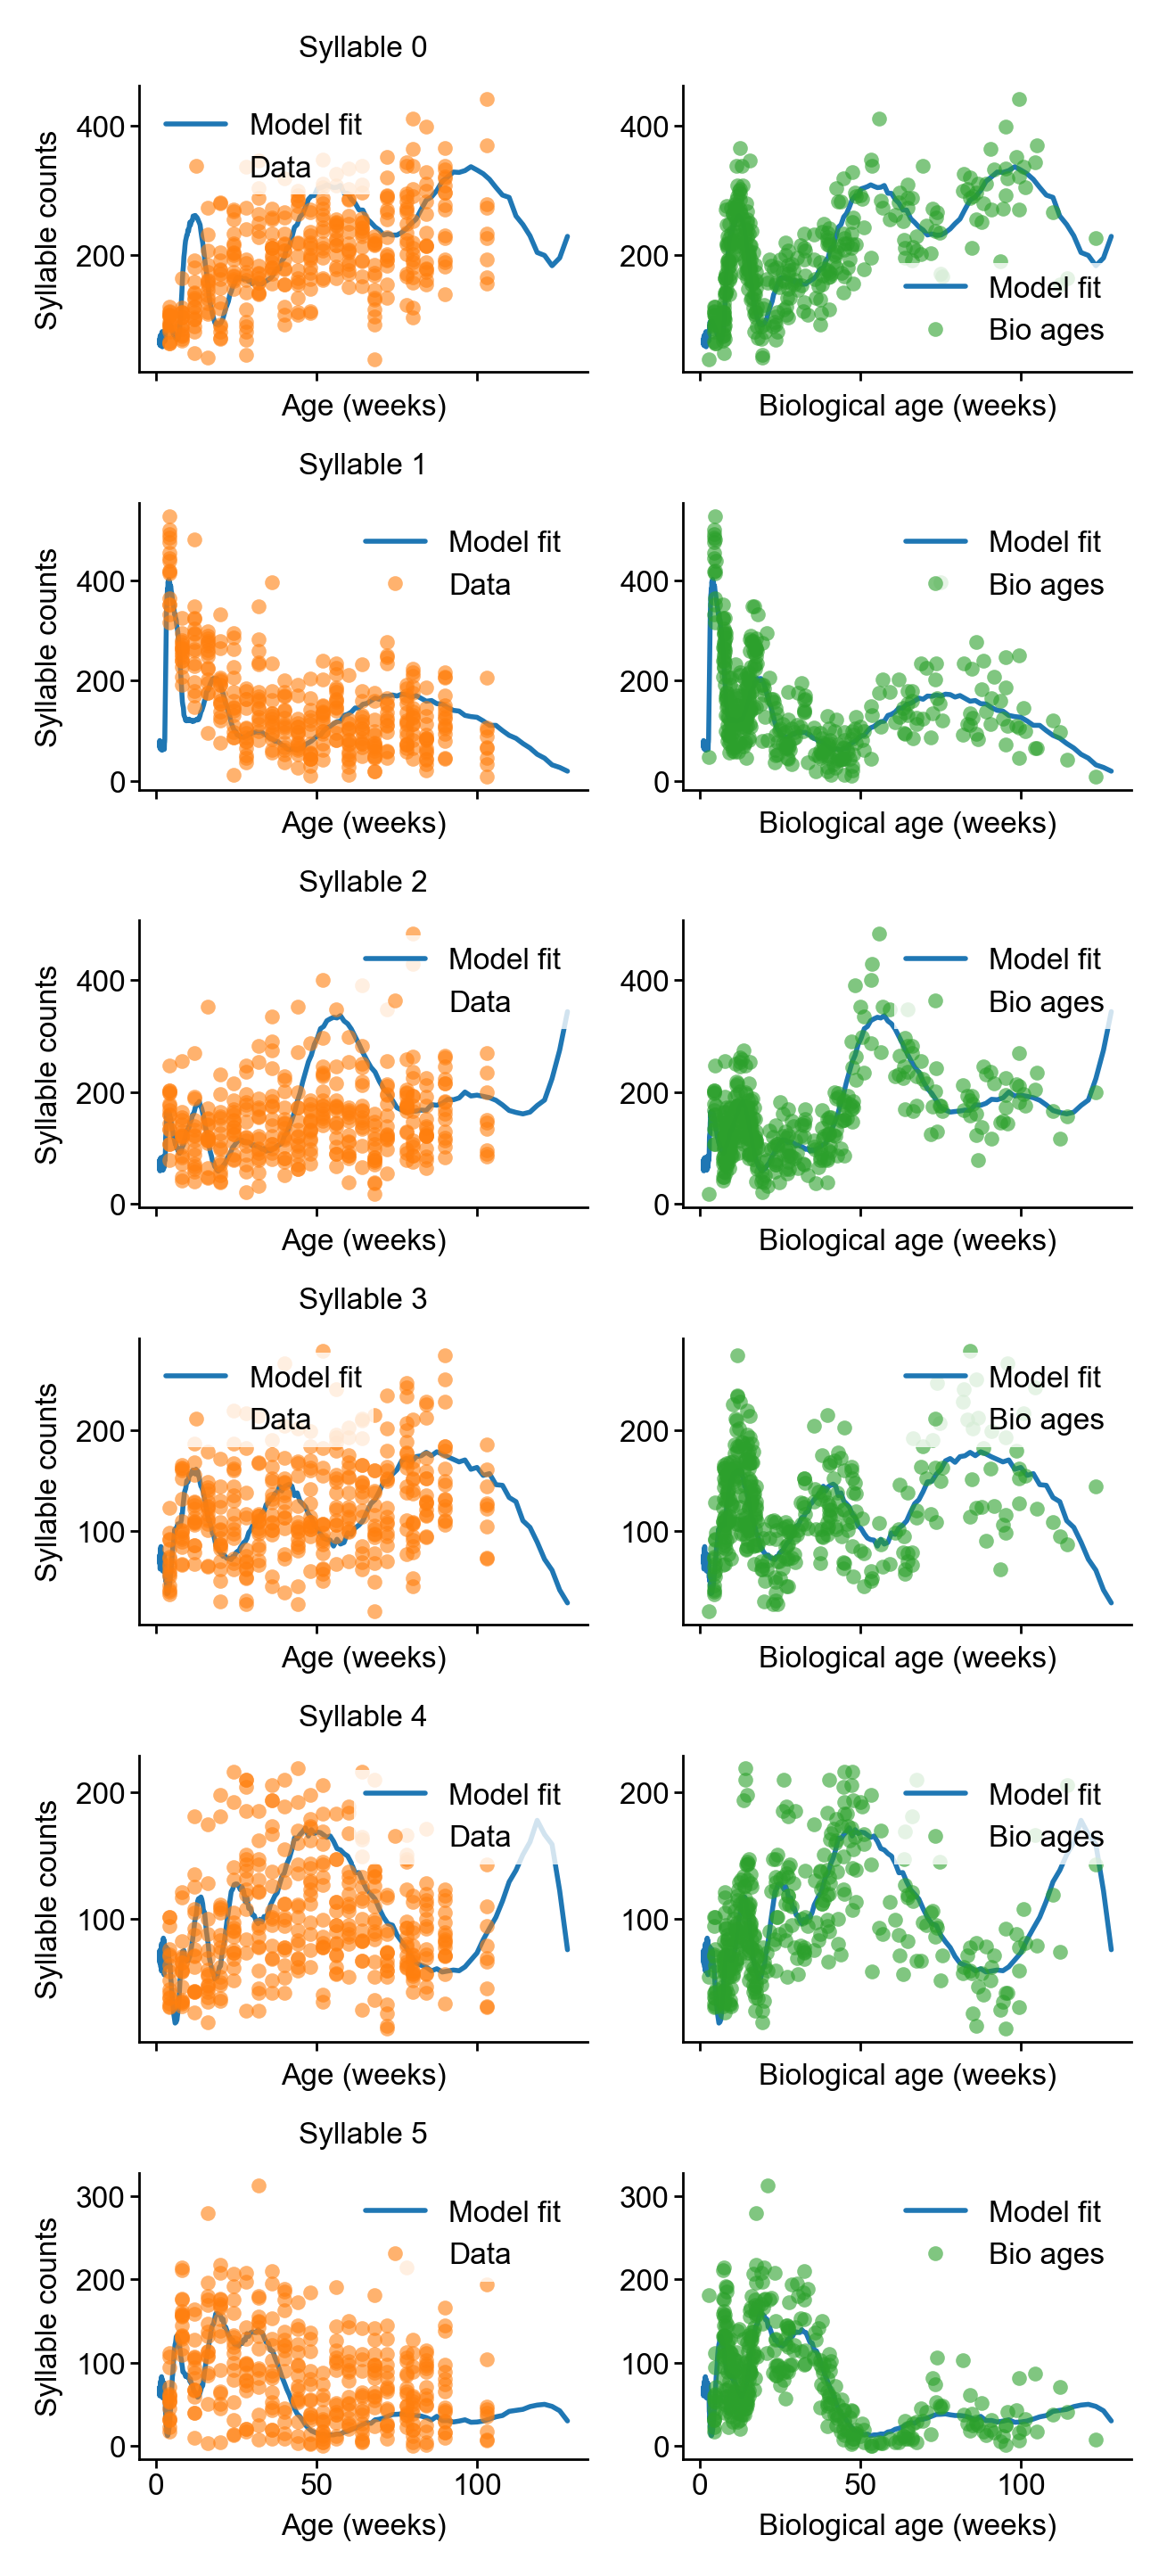

In [23]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()